# In this assignment we learn how to derive a neural network emultor based on the cosmopower emulator (Mancini et al. 2021). Based on this emualtor we perform a PCA data compression.

### For this assignment you need the install cosmopower yourself https://github.com/alessiospuriomancini/cosmopower or you just use the cosmopower_NN.py module that is provided. However in the latter case you need to install tensorflow: https://www.tensorflow.org/install

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy.linalg import inv
from cosmopower_NN import cosmopower_NN
import tensorflow as tf
from tqdm import tqdm

## Preparation: load in the all the 10000 model vectors and corresponding paramters that we use to bulit the emulator.

In [2]:
models = np.load('data_4_assignment2/models.npy') 
parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys(),models.shape

(KeysView(<numpy.lib.npyio.NpzFile object at 0x000001AFA3F863A0>),
 (10000, 900))

#### Divide the models and parameters in a training and test set. 

In [3]:
a, b = 7000, 10000
train_sample = np.arange(0,a) # select which elements you wanna use for training - first 70% of 10k
test_sample = np.arange(a,b) # select which elements you wanna use for testing - last 30% of 10k

train_params = {}
for name in parameters.keys():
    train_params[name]=list(np.array(parameters[name])[train_sample])
    
test_params = {}
for name in parameters.keys():
    test_params[name]=list(np.array(parameters[name])[test_sample])

train_features = np.load('data_4_assignment2/models.npy')[train_sample]
test_features = np.load('data_4_assignment2/models.npy')[test_sample]

#### Train the emulator. Reasonable hyper parameres are set already, but test out other settings and comment on what you observe regarding accuracy and speed.

In [10]:
#These premodifications are not necessary but might improve the accuracy
#Here you can try to modify the training features in advance
features_modified = (train_features - np.min(train_features, axis=0))/(np.max(train_features, axis=0) - \
                                                                       np.min(train_features, axis=0))

cp_nn = cosmopower_NN(parameters=list(parameters.keys()), 
                    modes=np.linspace(-1,1,train_features.shape[1]), 
                    n_hidden = [512, 512, 512, 512], # This you should modify. In this exmaple we use three layers with 4, 5 
                                                     # and 6 nodes. Is this enough?
                    verbose=True, # useful to understand the different steps in initialisation and training
                    )

device = 'cpu'
with tf.device(device):
    # train
    cp_nn.train(training_parameters=train_params,
                training_features=features_modified,
                filename_saved_model='data_4_assignment2/emulator_test_3', # the name of the emulator and where to save it
                # cooling schedule
                validation_split=0.1, # The precentage from train sample that is used for the validation
                learning_rates=[1e-2, 1e-3, 1e-4, 1e-5], # the different leanring rates. This need to be adjusted
                batch_sizes=[200, 200, 200, 200], # the number for models that are used to adjust the NN parameters
                gradient_accumulation_steps = [1, 1, 1, 1], # !!! Idk what this does but it doesnt work without this specified
                patience_values = [250, 250, 250, 200], # Number of epoch to wait before decreasing the learning rate if the 
                                                        # loss does not improve anymore
                max_epochs = [2000, 2000, 2000, 2000], # Maxmimal number of epoch before decreasing the learning rate
                )


Initialized cosmopower_NN model, 
mapping 4 input parameters to 900 output modes, 
using 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 

Starting cosmopower_NN training, 
using 10 per cent of training samples for validation. 
Performing 4 learning steps, with 
[0.01, 0.001, 0.0001, 1e-05] learning rates 
[200, 200, 200, 200] batch sizes 
[1, 1, 1, 1] gradient accumulation steps 
[250, 250, 250, 200] patience values 
[2000, 2000, 2000, 2000] max epochs 

learning rate = 0.01, batch size = 200


 54%|███████████████████████████████████▍                              | 1072/2000 [23:34<20:24,  1.32s/it, loss=0.002]


Validation loss = 0.0011154396
Model saved.
Reached max number of epochs. Validation loss = 0.0011154396
Model saved.
learning rate = 0.001, batch size = 200


 36%|███████████████████████▌                                         | 726/2000 [15:42<27:33,  1.30s/it, loss=0.00023]


Validation loss = 0.00012259527
Model saved.
Reached max number of epochs. Validation loss = 0.00012259527
Model saved.
learning rate = 0.0001, batch size = 200


 13%|████████▍                                                        | 261/2000 [06:30<43:23,  1.50s/it, loss=8.38e-5]


Validation loss = 8.059048e-05
Model saved.
Reached max number of epochs. Validation loss = 8.059048e-05
Model saved.
learning rate = 1e-05, batch size = 200


 10%|██████▌                                                          | 201/2000 [04:18<38:32,  1.29s/it, loss=6.98e-5]

Validation loss = 6.779442e-05
Model saved.
Reached max number of epochs. Validation loss = 6.779442e-05
Model saved.


#### Check the accuracy of the emulator, by computing how many predictions are inside 68%, 95%, 99%.

In [4]:
# Load the model from save
cp_nn = cosmopower_NN(restore=True, restore_filename='data_4_assignment2/emulator_test_2')

[(-1.0, 1.0), (0.0, 899.0)]

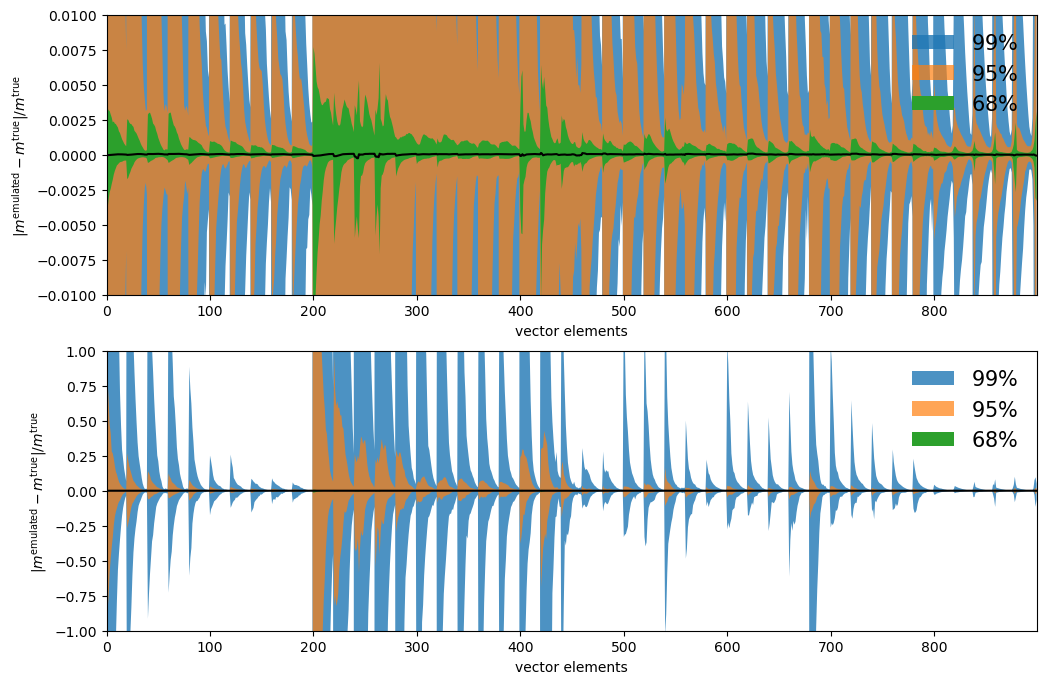

In [5]:
emulated_features = cp_nn.predictions_np(test_params)
# if you modified the training features you need to convert back the output back the original data vectors
emulated_features = (np.max(train_features, axis=0)-np.min(train_features, axis=0))*emulated_features + \
                     np.min(train_features, axis=0)

diff = (emulated_features-test_features)/test_features # Measure the relative difference between test sample and the 
                                                       # emualted models

mean_diff = np.median(diff,axis=0)
percentiles1 = np.percentile(diff, [0.5,99.5], axis=0)
percentiles2 = np.percentile(diff, [2.5,97.5], axis=0)
percentiles3 = np.percentile(diff, [16,84], axis=0)
bins=range(diff.shape[1])

fig, ax = plt.subplots(2,1,figsize=(12, 8),dpi=100)
ax[0].fill_between(bins, percentiles1[0], percentiles1[1],  label = '$99\%$', alpha=0.8)
ax[0].fill_between(bins, percentiles2[0], percentiles2[1], label = '$95\%$', alpha = 0.7)
ax[0].fill_between(bins, percentiles3[0], percentiles3[1],  label = '$68\%$', alpha = 1)
ax[0].plot(bins,mean_diff,'-',color='black')
# ax[0].xticks(fontsize=15)
# ax[0].yticks(fontsize=15)
ax[0].legend(frameon=False, fontsize=15, loc='upper right')
ax[0].set(ylabel=r'$| m^{\mathrm{emulated}} - m^{\mathrm{true}}|/  m^{\mathrm{true}}$', xlabel=r'vector elements')
ylim = 1e-2
ax[0].set(ylim=(-ylim,ylim), xlim=(0,899))

ax[1].fill_between(bins, percentiles1[0], percentiles1[1],  label = '$99\%$', alpha=0.8)
ax[1].fill_between(bins, percentiles2[0], percentiles2[1], label = '$95\%$', alpha = 0.7)
ax[1].fill_between(bins, percentiles3[0], percentiles3[1],  label = '$68\%$', alpha = 1)
ax[1].plot(bins,mean_diff,'-',color='black')
# ax[1].xticks(fontsize=15)
# ax[1].yticks(fontsize=15)
ax[1].legend(frameon=False, fontsize=15, loc='upper right')
ax[1].set(ylabel=r'$| m^{\mathrm{emulated}} - m^{\mathrm{true}}|/  m^{\mathrm{true}}$', xlabel=r'vector elements')
ylim = 1e0
ax[1].set(ylim=(-ylim,ylim), xlim=(0,899))

##### Next we want perform a Fisher Analysis using the emulator. We want you to compute the covariance of the parameters $\Theta = \{\Omega_\mathrm{m},w\}$, which can be estimated by $C(\Theta) = F^{-1}$, where $$F_{ij}= \left(\frac{\partial m(\Theta)}{\partial \Theta_i}\right)^{T} C^{-1} \left(\frac{\partial m(\Theta)}{\partial \Theta_i}\right)$$
##### For the partial derivatives we use the five point stencil beam given by $$\frac{\partial m(\Theta)}{\partial \Theta_i}\approx \frac{-m(\Theta_i + 2\ \Delta \Theta_i) + 8 \ m(\Theta_i +  \Delta \Theta_i) - 8 \ m(\Theta_i - \Delta \Theta_i) + m(\Theta_i - 2\ \Delta \Theta_i)}{12 \ \Delta \Theta_i }$$

In [6]:
Om_shift = (np.max(test_params['omega_m']) - np.min(test_params['omega_m']))/1e3 #decide for a reasonable stepsize in Omega_m
w_shift = (np.max(test_params['w']) - np.min(test_params['w']))/1e3 #decide for a reasonable stepsize in w

# This example compute the model for two different Omega_m values.
# paramters = {'omega_m':[0.3,0.31,],'w':[-1,-1],'As':[np.mean(test_params['As'])]*2,'omega_b':[np.mean(test_params['omega_b'])]*2}
paramters = {'omega_m':[np.mean(test_params['omega_m']) + 2*Om_shift, np.mean(test_params['omega_m']) + Om_shift, \
                        np.mean(test_params['omega_m']) - Om_shift, np.mean(test_params['omega_m']) - 2*Om_shift],\
             'w':[np.mean(test_params['w'])]*4,'As':[np.mean(test_params['As'])]*4,\
             'omega_b':[np.mean(test_params['omega_b'])]*4}

paramters2 = {'omega_m':[np.mean(test_params['omega_m'])]*4,'As':[np.mean(test_params['As'])]*4,\
              'omega_b':[np.mean(test_params['omega_b'])]*4,\
              'w':[np.mean(test_params['w']) + 2*w_shift, np.mean(test_params['w']) + w_shift, \
                   np.mean(test_params['w']) - w_shift, np.mean(test_params['w']) - 2*w_shift]}
    
features_4_div = cp_nn.predictions_np(paramters)
features_4_div2 = cp_nn.predictions_np(paramters2)
# if you modified the training features you need to convert back the output back the original data vectors
features_4_div = (np.max(train_features,axis=0)-np.min(train_features,axis=0))*features_4_div + \
                  np.min(train_features,axis=0)
features_4_div2 = (np.max(train_features,axis=0)-np.min(train_features,axis=0))*features_4_div2 + \
                   np.min(train_features,axis=0)

# compute derivatives
derivative_Om = (-features_4_div[0] + 8*features_4_div[1] - 8*features_4_div[2] + features_4_div[3])/(12*Om_shift)
derivative_w = (-features_4_div2[0] + 8*features_4_div2[1] - 8*features_4_div2[2] + features_4_div2[3])/(12*w_shift)

#### So lets compute the Fisher matrix the corresponding covariance matrix of the paramters:

In [31]:
cov=np.load('data_4_assignment1/covariance.npy') # We make use of the analy
inv_cov = inv(cov)

FoM_11 = np.matmul(np.matmul(derivative_Om.T, inv_cov), derivative_Om)
FoM_22 = np.matmul(np.matmul(derivative_w.T, inv_cov), derivative_w)
FoM_12 = np.matmul(np.matmul(derivative_Om.T, inv_cov), derivative_w)
FoM_best = np.array([[FoM_11,FoM_12],[FoM_12,FoM_22]])

Cov_parameter = inv(FoM_best)
Cov_parameter,np.sqrt(np.diag(Cov_parameter))

(array([[6.11945882e-07, 1.16097443e-05],
        [1.16097443e-05, 3.14257822e-04]]),
 array([0.00078227, 0.01772732]))

#### First you need to generate the transformation from our model/data vectors to the PCA elements based on the 10k models. Then you need transform all 100k noisy data vectors from which you should then measure the covariance on the PCA elements. Now it should get clear why you had to generate the 100k multvariate Gaussian random variables. 

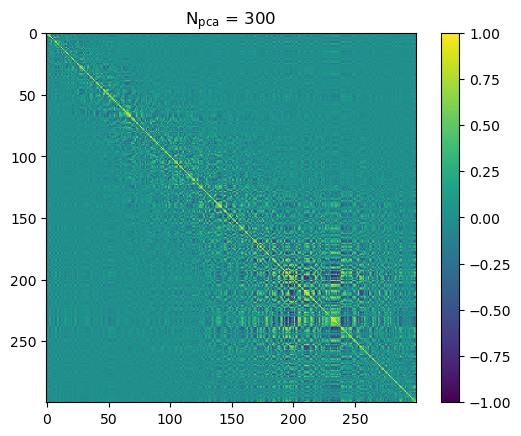

In [40]:
from sklearn.decomposition import PCA

N_pca = 300 # Decide how many PCA eigenvalues you want to use
models = np.load('data_4_assignment2/models.npy')
mean = np.mean(models,axis=0) # for numerical stability you should subtract the mean of each element
pca = PCA(n_components=N_pca,svd_solver='full')
models_pca = pca.fit_transform(models-mean) # Perform the PCA fitting. Now you can use pca for the transformation

#rotate covariance matrix. If you do not how to do that. You can also create 10k random data vectors and tranform each one
# individualy, and then compute the covariance matrix from them
rotation_matrix = pca.components_.T
cov_pca = np.matmul(np.matmul(rotation_matrix.T,cov),rotation_matrix)

plt.imshow(cov_pca/np.outer(np.sqrt(np.diag(cov_pca)),np.sqrt(np.diag(cov_pca))),vmin=-1)
plt.colorbar()
plt.title("N$_{\mathrm{pca}}$ = 300")
plt.show()

#### Increase successively the number of PCA elements from which you compute the Fisher matrix. Convince yourself that if you take all possible PCA elements you converge to same contraining power as for original Fisher analysis. How many PCA elements do you need to have 10% and 1% of the constraining power as the original Fisher analysis?

In [42]:
paramter_constraints = []

N_pca = 900
models = np.load('data_4_assignment2/models.npy')
mean = np.mean(models,axis=0)
pca = PCA(n_components=N_pca,svd_solver='full')
models_pca = pca.fit_transform(models-mean)
rotation_matrix = pca.components_.T
cov_pca = np.matmul(np.matmul(rotation_matrix.T,cov),rotation_matrix)

for n_pca in tqdm(np.arange(1,N_pca)):
    
    inv_cov_pca = inv(cov_pca[:n_pca,:n_pca]) # select the first n_pca elements

    features_4_div_pca = pca.transform(features_4_div - mean)[:,:n_pca] # transform the derivative and select the first N_pca 
                                                                        # elements
    features_4_div_pca2 = pca.transform(features_4_div2 - mean)[:,:n_pca]

    derivative_Om_pca = (-features_4_div_pca[0] + 8*features_4_div_pca[1] - 8*features_4_div_pca[2] + \
                         features_4_div_pca[3])/(12*Om_shift) # compute derivative
    derivative_w_pca = (-features_4_div_pca2[0] + 8*features_4_div_pca2[1] - 8*features_4_div_pca2[2] + \
                        features_4_div_pca2[3])/(12*w_shift) # compute derivative

#     FoM_11 = np.matmul(np.matmul(derivative_Om_pca.T, inv_cov_pca), derivative_Om_pca)
#     FoM_22 = np.matmul(np.matmul(derivative_w_pca.T, inv_cov_pca), derivative_w_pca)
#     FoM_12 = np.matmul(np.matmul(derivative_Om_pca.T, inv_cov_pca), derivative_w_pca)
    FoM_11 = np.matmul(derivative_Om_pca.T, np.matmul(inv_cov_pca, derivative_Om_pca))
    FoM_22 = np.matmul(derivative_w_pca.T, np.matmul(inv_cov_pca, derivative_w_pca))
    FoM_12 = np.matmul(derivative_Om_pca.T, np.matmul(inv_cov_pca, derivative_w_pca))
    FoM_best_pca = np.array([[FoM_11,FoM_12],[FoM_12,FoM_22]])

    Cov_parameter_pca = inv(FoM_best_pca)
    paramter_constraints.append(np.sqrt(np.diag(Cov_parameter_pca)))
paramter_constraints = np.array(paramter_constraints)

  0%|                                                                                          | 0/899 [00:00<?, ?it/s]C:\Users\lpgig00133\AppData\Local\Temp\ipykernel_1384\50903441.py:32: RuntimeWarning: invalid value encountered in sqrt
  paramter_constraints.append(np.sqrt(np.diag(Cov_parameter_pca)))
100%|███████████████████████████████████████████████████████████████████████████████| 899/899 [00:07<00:00, 127.20it/s]


### Plot the constraints depending on the number of PCA that you have used. How many PCA elements do you need to get 10% and 1% of the maximum constraining power.

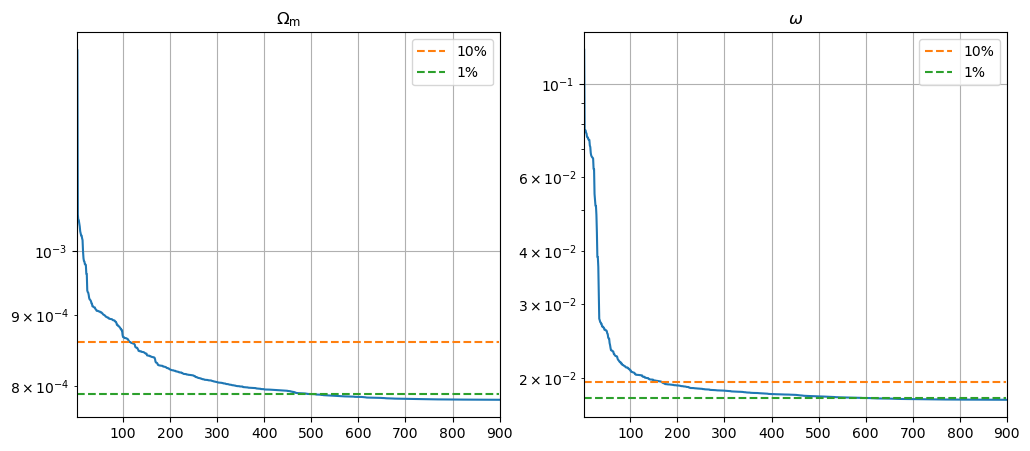

In [44]:
omega_m_10 = np.sqrt(np.diag(Cov_parameter_pca))[0]*1.1
omega_m_1 = np.sqrt(np.diag(Cov_parameter_pca))[0]*1.01
omega_w_10 = np.sqrt(np.diag(Cov_parameter_pca))[1]*1.1
omega_w_1 = np.sqrt(np.diag(Cov_parameter_pca))[1]*1.01

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(np.arange(2,N_pca),paramter_constraints[1:,0])
ax[0].plot(np.arange(2,N_pca), omega_m_10*np.ones(len(np.arange(2,N_pca))), ls='--', label='10%')
ax[0].plot(np.arange(2,N_pca), omega_m_1*np.ones(len(np.arange(2,N_pca))), ls='--', label='1%')
ax[0].set(yscale='log', title='$\Omega_{\mathrm{m}}$', xlim=(2,900))
ax[0].grid()
ax[0].legend()

ax[1].plot(np.arange(2,N_pca),paramter_constraints[1:,1])
ax[1].plot(np.arange(2,N_pca), omega_w_10*np.ones(len(np.arange(2,N_pca))), ls='--', label='10%')
ax[1].plot(np.arange(2,N_pca), omega_w_1*np.ones(len(np.arange(2,N_pca))), ls='--', label='1%')
ax[1].set(yscale='log', title='$\omega$', xlim=(2,900))
ax[1].grid()
ax[1].legend()

In [39]:
omega_m_10_ind = np.where(paramter_constraints[1:,0] <= omega_m_10)[0][0]
omega_m_1_ind = np.where(paramter_constraints[1:,0] <= omega_m_1)[0][0]

omega_w_10_ind = np.where(paramter_constraints[1:,1] <= omega_w_10)[0][0]
omega_w_1_ind = np.where(paramter_constraints[1:,1] <= omega_w_1)[0][0]

print('Omega_m:\n 10% constraining power reached at',omega_m_10_ind,' PCA elements,\n 1% constraining power reached at',\
      omega_m_1_ind,' PCA elements.\n')
print('omega:\n 10% constraining power reached at',omega_w_10_ind,' PCA elements,\n 1% constraining power reached at',\
      omega_w_1_ind,' PCA elements.')

Omega_m:
 10% constraining power reached at 112  PCA elements,
 1% constraining power reached at 489  PCA elements.

omega:
 10% constraining power reached at 166  PCA elements,
 1% constraining power reached at 590  PCA elements.
